In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os
from scipy.stats import ttest_ind, zscore
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor




from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')


#plt.style.use("fivethirtyeight")
plt.style.use("ggplot")
#sns.set_style("white")



In [13]:
class cfg :
    figsize = (10,6)
    csv_path = "./insurance.csv"

In [14]:
df=pd.read_csv("./insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [15]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [4]:
# from sklearn.preprocessing import LabelEncoder
# #sex
# le = LabelEncoder()
# le.fit(data.sex.drop_duplicates()) 
# data.sex = le.transform(data.sex)
# # smoker or not
# le.fit(data.smoker.drop_duplicates()) 
# data.smoker = le.transform(data.smoker)
# #region
# le.fit(data.region.drop_duplicates()) 
# data.region = le.transform(data.region)

ModuleNotFoundError: No module named 'sklearn'

male은 1, female은 0
smoker는 1
region 
southwest 3
southeast 2
northwest 1
northeast 0

BMI분포도

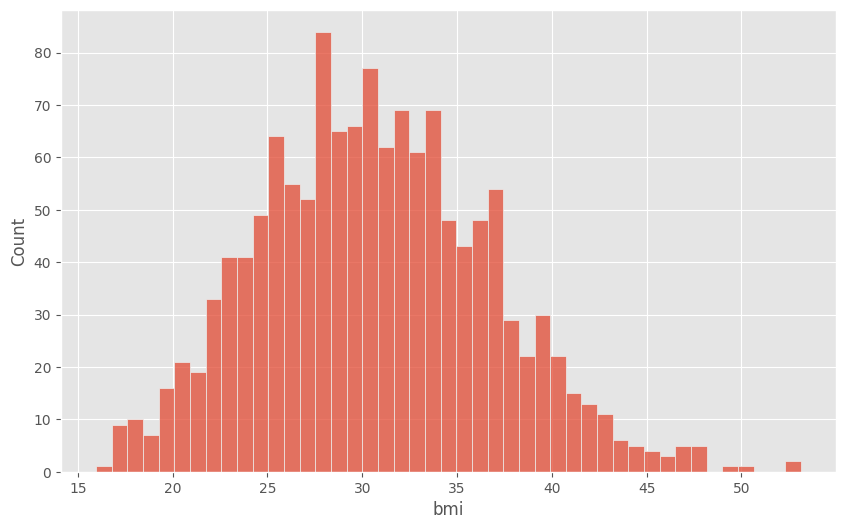

In [16]:
plt.figure(figsize=cfg.figsize)
sns.histplot(data=df, x='bmi',bins=45, )
plt.show()

BMI 분포에 대한 기초 통계값

In [18]:
df.bmi.describe()

count    1338.000000
mean       30.663397
std         6.098187
min        15.960000
25%        26.296250
50%        30.400000
75%        34.693750
max        53.130000
Name: bmi, dtype: float64

BMI 분포에 대한 비대칭도(skew)


-skew는 왜도 또는 비대칭도 라고도 하며, 평균에 대해 최빈값이 얼마나 치우쳐져있는지를 나타내는 척도입니다

In [20]:
df.bmi.skew()
# 평균에서 약간 우측으로 치우쳐져 있어 양의 비대칭도를 가짐을 알수 있습니다.


0.2840471105987448

<Axes: xlabel='bmi'>

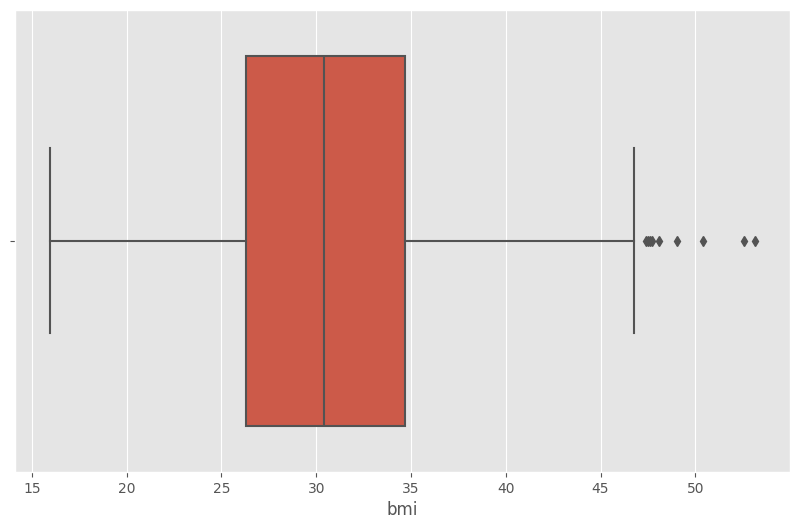

In [21]:
plt.figure(figsize=cfg.figsize)
sns.boxplot(data=df, x='bmi')


"BMI와 성별 간의 관계를 조사하십시오."

In [22]:
df.groupby('sex').describe()['bmi']

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
female,662.0,30.377749,6.046023,16.815,26.125,30.1075,34.31375,48.07
male,676.0,30.943129,6.140435,15.960,26.410,30.6875,34.99250,53.13


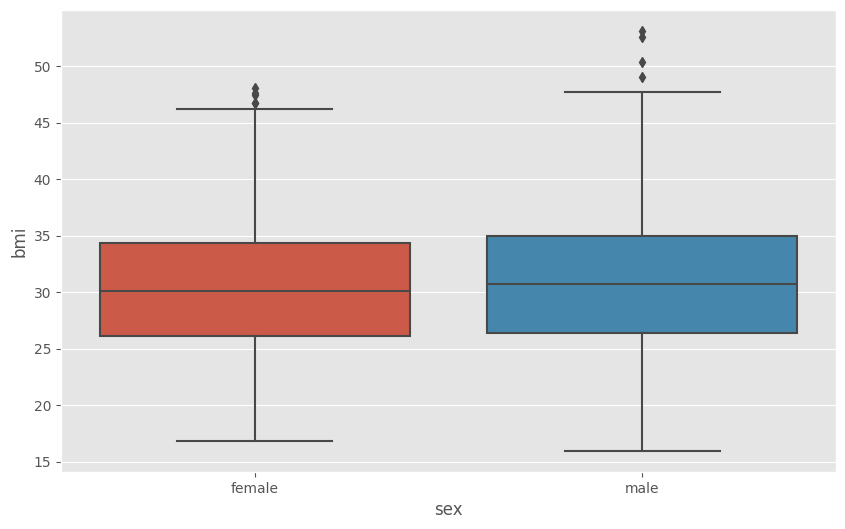

In [25]:
plt.figure(figsize=cfg.figsize)
sns.boxplot(data=df, x ='sex', y='bmi')
plt.show()

# 성은 bmi분포에 영향을 미치지 않는듯 보인다

In [26]:
male_bmi = df[df['sex'] == 'male']['bmi'].values
female_bmi = df[df['sex'] == 'female']['bmi'].values

p_value = 0.05
ttest_ind(male_bmi, female_bmi)

TtestResult(statistic=1.696752635752224, pvalue=0.08997637178984934, df=1336.0)

나이와 BMI 사이의 관계를 조사

<Figure size 1000x1000 with 0 Axes>

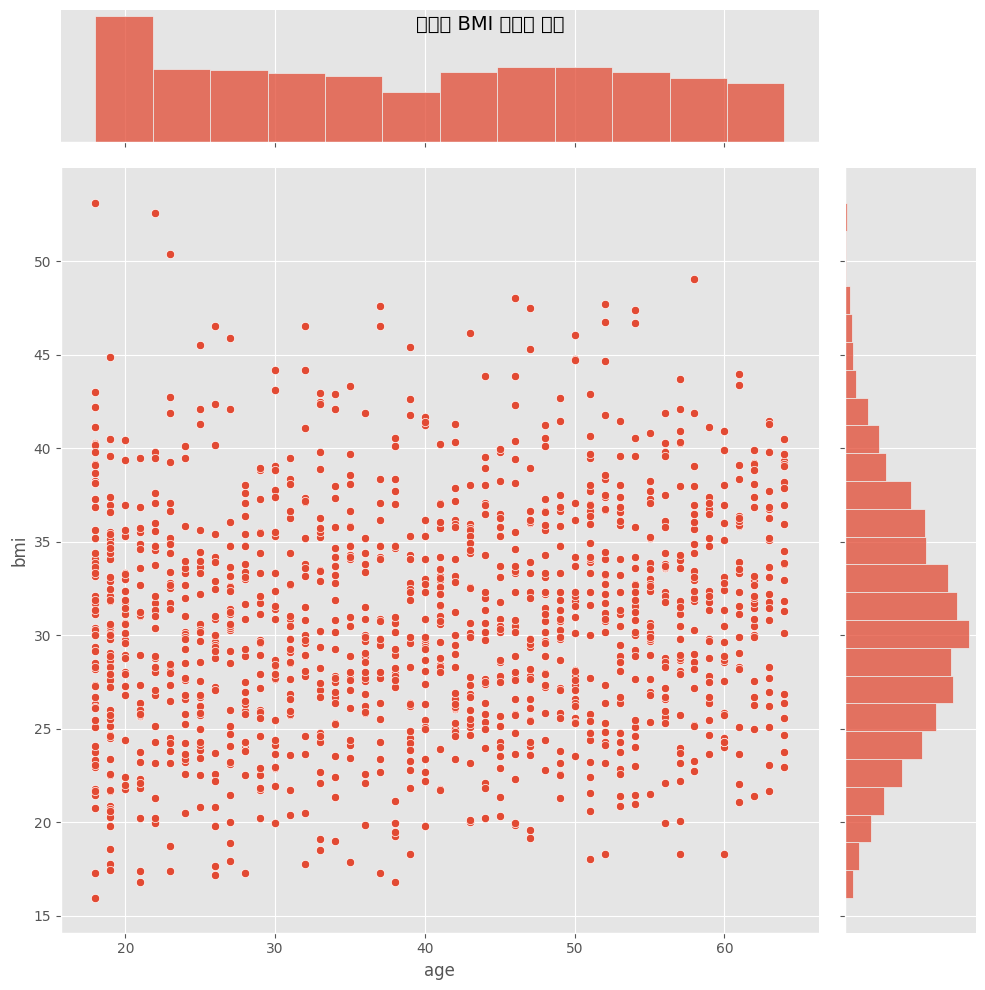

In [36]:
plt.figure(figsize=(10,10))
sns.jointplot(data=df, x='age', y='bmi', height= 10)
plt.suptitle('Relationship between Age and BMI', fontsize=14)
plt.show()

Examine the relationship between bmi and children

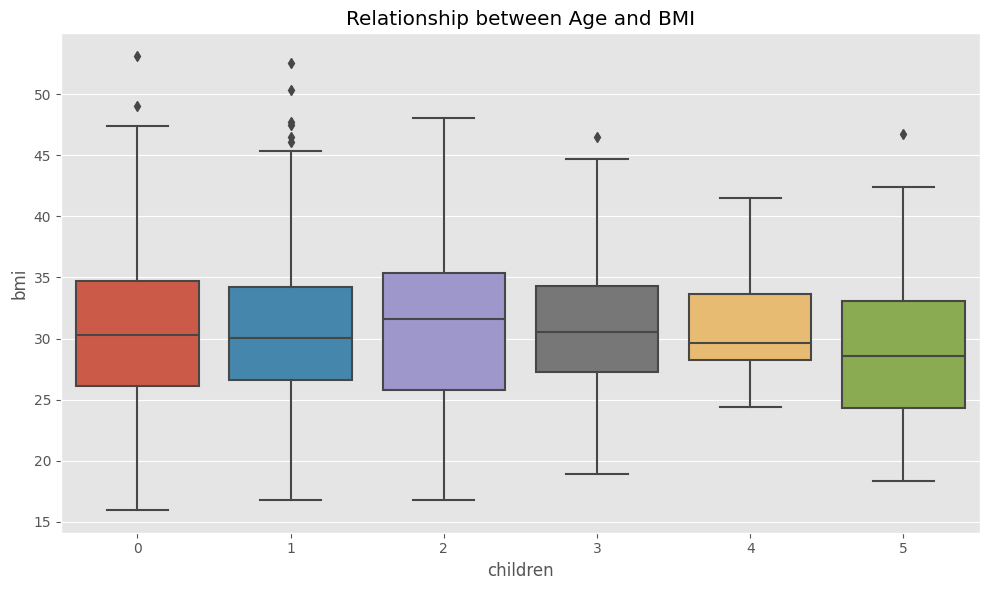

In [29]:
plt.figure(figsize=cfg.figsize)
sns.boxplot(data=df, x='children', y='bmi',)
plt.title('Relationship between Age and BMI', )
plt.tight_layout()
plt.show()

In [30]:
print(f"Correlation betwween BMI and Children is: {(df.bmi.corr(df.children)):.4f}")

Correlation betwween BMI and Children is: 0.0128


"지역 and 흡연 여부와 BMI 간의 관계를 막대 그래프를 사용하여 조사하십시오."

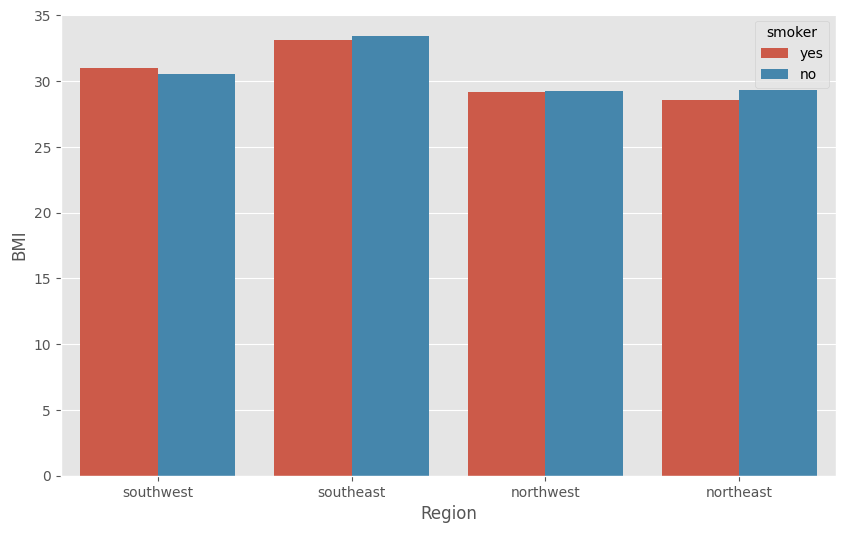

In [31]:
plt.figure(figsize=cfg.figsize)
sns.barplot(data=df, x='region', y='bmi', hue='smoker', errorbar=None)
plt.xlabel("Region")
plt.ylabel('BMI')
plt.show()

"남동부 지역은 흡연자와 비흡연자 모두에서 가장 높은 BMI를 가지고 있습니다. 이 데이터셋에서는 흡연자가 높은 BMI를 가지고 있다는 명확한 지표가 없습니다. 아래의 조인트 플롯에서도 확인할 수 있습니다."

<Figure size 1000x600 with 0 Axes>

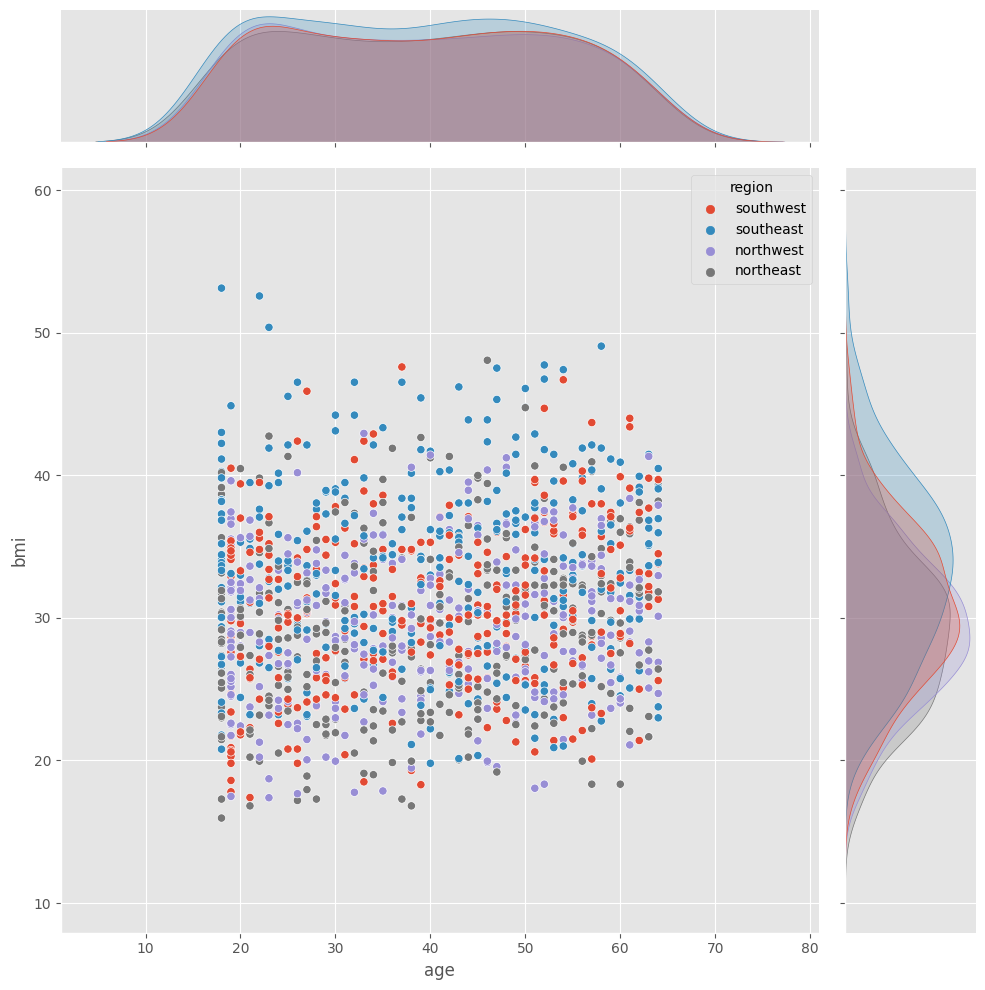

In [32]:
plt.figure(figsize=cfg.figsize)
sns.jointplot(data=df, x='age', y='bmi', hue='region', height= 10, )
plt.show()

"BMI와 의료비 간의 관계를 조사하십시오."

In [37]:
bmi_charges_corr = df.bmi.corr(df.charges)

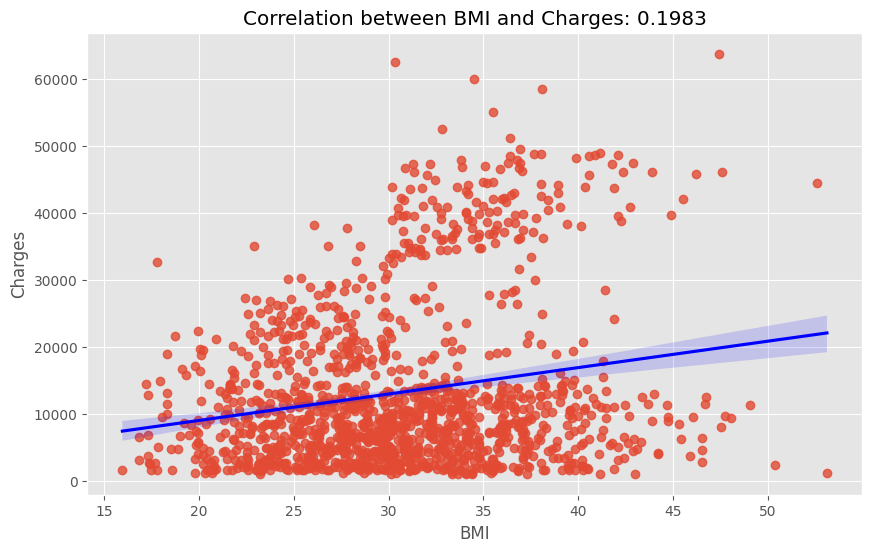

In [34]:
plt.figure(figsize=cfg.figsize)
sns.regplot(data=df, x='bmi', y='charges', line_kws={'color':'blue'})
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.title(f"Correlation between BMI and Charges: {bmi_charges_corr:.4f}")
plt.show()